<center> <span style="font-size:30px;"><span style="color:black;"><b>SC1015 Mini Project</b></span></span> </center>
<br>
<center> <span style="font-size:30px;"><span style="color:black;"><b>Heart Disease Predictor</b></span></span> </center>


# Importing of Required Libraries

In [1]:
!pip install plotly-express

In [2]:
!pip list


Package                       Version
----------------------------- ---------------
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8

In [3]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
import plotly_express as px

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score , ConfusionMatrixDisplay , classification_report, confusion_matrix
import warnings


# 1. Analyse of Data
For our mini-project we will be using the FramingHam data set from Kaggle. The aim of this project is to predict if a patient has a 10 years risk of future (CHD) coronary heart disease.
<br>
We will begin by importing the data and going through the variables in the data set

In [4]:
heartData = pd.read_csv('framingham.csv')
heartData.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
# Information about the Variables
heartData.info()
heartData.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


(4238, 16)

In [6]:
heartData.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


Summary of results

# 2. Cleaning/Preprocessing of Data

## Missing Value Cleaning
Check to see if there is any null values in the data set

In [7]:
# Percentage of null values in each column
(heartData.isnull().sum()/heartData.shape[0])*100

male               0.000000
age                0.000000
education          2.477584
currentSmoker      0.000000
cigsPerDay         0.684285
BPMeds             1.250590
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179802
sysBP              0.000000
diaBP              0.000000
BMI                0.448325
heartRate          0.023596
glucose            9.155262
TenYearCHD         0.000000
dtype: float64

In [8]:
#Median to fill 0 values if diabetes is 1
diabetesIs1_data = heartData[heartData['diabetes']==1]
median_glucose_diabetes_1 = diabetesIs1_data['glucose'].median()
#Median to fill 0 values if currentSmoker is 0
currentSmokerIs0_data = heartData[heartData['currentSmoker']==0]
median_heartRate_currentSmoker_0 = currentSmokerIs0_data['heartRate'].median()

heartData['education'].fillna(0,inplace=True)
heartData['cigsPerDay'].fillna(heartData['cigsPerDay'].where(heartData['currentSmoker']==1).median(),inplace=True)
heartData['cigsPerDay'].fillna(0,inplace=True)
heartData['BPMeds'].fillna(0,inplace=True)
heartData['totChol'].fillna(heartData['totChol'].median(),inplace=True)
heartData['BMI'].fillna(heartData['BMI'].median(),inplace=True)
heartData['heartRate'].fillna(heartData['heartRate'].where(heartData['currentSmoker']==1).median(),inplace=True)
heartData['heartRate'].fillna(median_heartRate_currentSmoker_0,inplace=True)
heartData['glucose'].fillna(heartData['glucose'].where(heartData['diabetes']==0).median(),inplace=True)
heartData['glucose'].fillna(median_glucose_diabetes_1,inplace=True)

In [9]:
# Checking if there are any misisng values:
(heartData.isnull().sum()/heartData.shape[0])*100

male               0.0
age                0.0
education          0.0
currentSmoker      0.0
cigsPerDay         0.0
BPMeds             0.0
prevalentStroke    0.0
prevalentHyp       0.0
diabetes           0.0
totChol            0.0
sysBP              0.0
diaBP              0.0
BMI                0.0
heartRate          0.0
glucose            0.0
TenYearCHD         0.0
dtype: float64

## Outlier cleaning
Identify which variables needs outliers cleaning and remove the outlier rows

In [10]:
# Backing up data sets for any just in case
heartData_Copy = heartData.copy()

male                 0
age                  0
education            0
currentSmoker        0
cigsPerDay          12
BPMeds             124
prevalentStroke     25
prevalentHyp         0
diabetes           109
totChol             57
sysBP              126
diaBP               81
BMI                 97
heartRate           76
glucose            262
TenYearCHD         644
dtype: int64


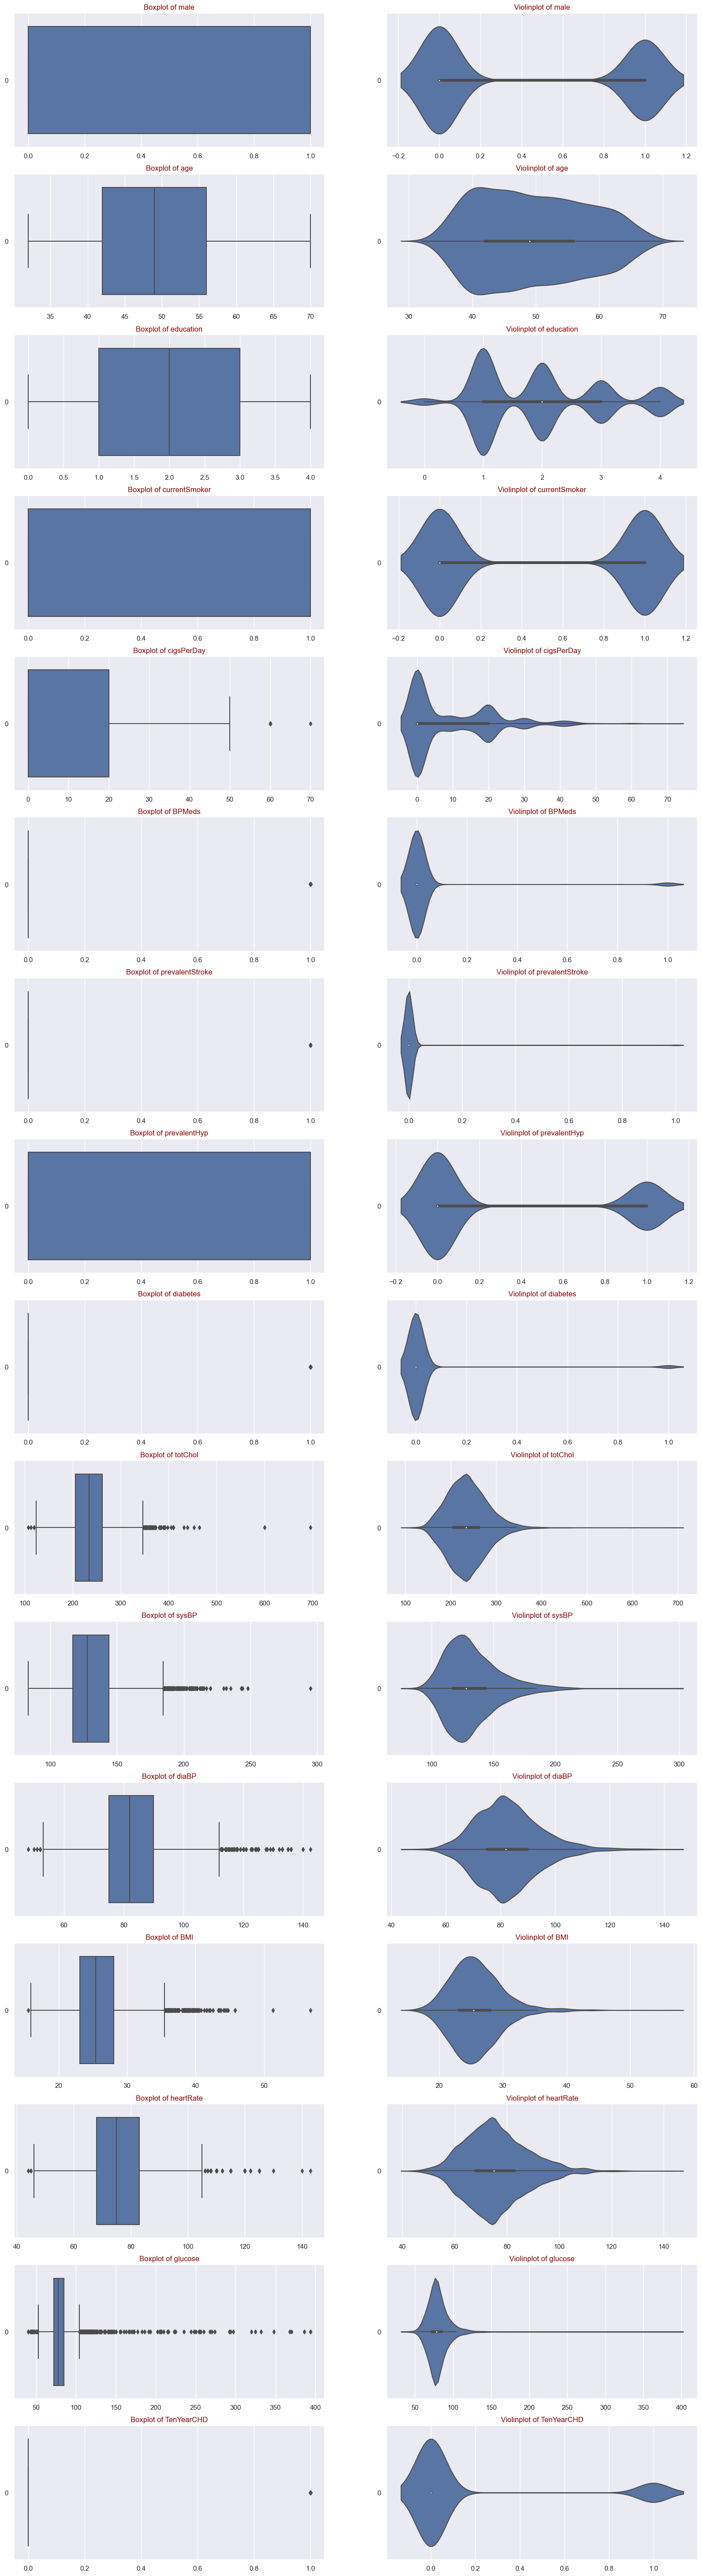

In [11]:
# Draw the distributions of all variables
f, axes = plt.subplots(16, 2, figsize=(20,75))

count = 0
for var in heartData:
    sb.boxplot(data = heartData[var], orient = "h", ax = axes[count,0])
    axes[count,0].set_title(f'Boxplot of {var}', color='DarkRed')  
    sb.violinplot(data = heartData[var], orient = "h", ax = axes[count,1])
    axes[count,1].set_title(f'Violinplot of {var}', color='DarkRed') 
    count += 1
    
#Calculate outliers
Q1 = heartData.quantile(0.25)
Q3 = heartData.quantile(0.75)
IQR = Q3 - Q1
print (((heartData < (Q1 - 1.5 * IQR)) | (heartData > (Q3 + 1.5 * IQR))).sum())

In [12]:
# Extracting variables that requires outlier remove
outlier_variables = ['cigsPerDay','totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [13]:
# To remove outliers
for var in outlier_variables:
    Q1 = heartData[var].quantile(0.25)
    Q3 = heartData[var].quantile(0.75)
    IQR = Q3 - Q1
    UL = Q3 + 1.5 * IQR
    LL = Q1 - 1.5 * IQR
    heartData = heartData[(heartData[var] < UL) & (heartData[var] > LL)] 

In [14]:
print('There were {} rows before outlier treatment.'.format(heartData_Copy.shape[0]))
print('There are {} rows after outlier treatment.'.format(heartData.shape[0]))
print('After outlier treatment number of rows lost are {}.'.format(heartData_Copy.shape[0] - heartData.shape[0]))

There were 4238 rows before outlier treatment.
There are 3620 rows after outlier treatment.
After outlier treatment number of rows lost are 618.


# 3. Exploratory Analysis
Now we have a processed data set, we will start by finding out which variables play a strong factor in determining the final prediction result.
<br>
First lets explore each variables by generating various graphs.


In [15]:
heartData.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000
mean,0.438950,49.024862,1.966022,0.501657,9.127901,0.020442,0.004972,0.261878,0.005249,233.737845,128.824862,81.415608,25.376820,74.628177,77.904144,0.133149
std,0.496327,8.482216,1.056673,0.500066,11.611299,0.141526,0.070349,0.439718,0.072267,39.917808,17.907190,10.285533,3.454602,10.809735,9.813933,0.339783
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.000000,83.500000,53.000000,16.480000,45.000000,53.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,115.500000,74.000000,22.927500,67.000000,72.000000,0.000000
50%,0.000000,48.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,232.000000,126.000000,81.000000,25.160000,75.000000,78.000000,0.000000
75%,1.000000,55.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,260.000000,140.000000,88.000000,27.680000,80.000000,84.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,45.000000,1.000000,1.000000,1.000000,1.000000,345.000000,183.000000,110.000000,35.200000,104.000000,104.000000,1.000000


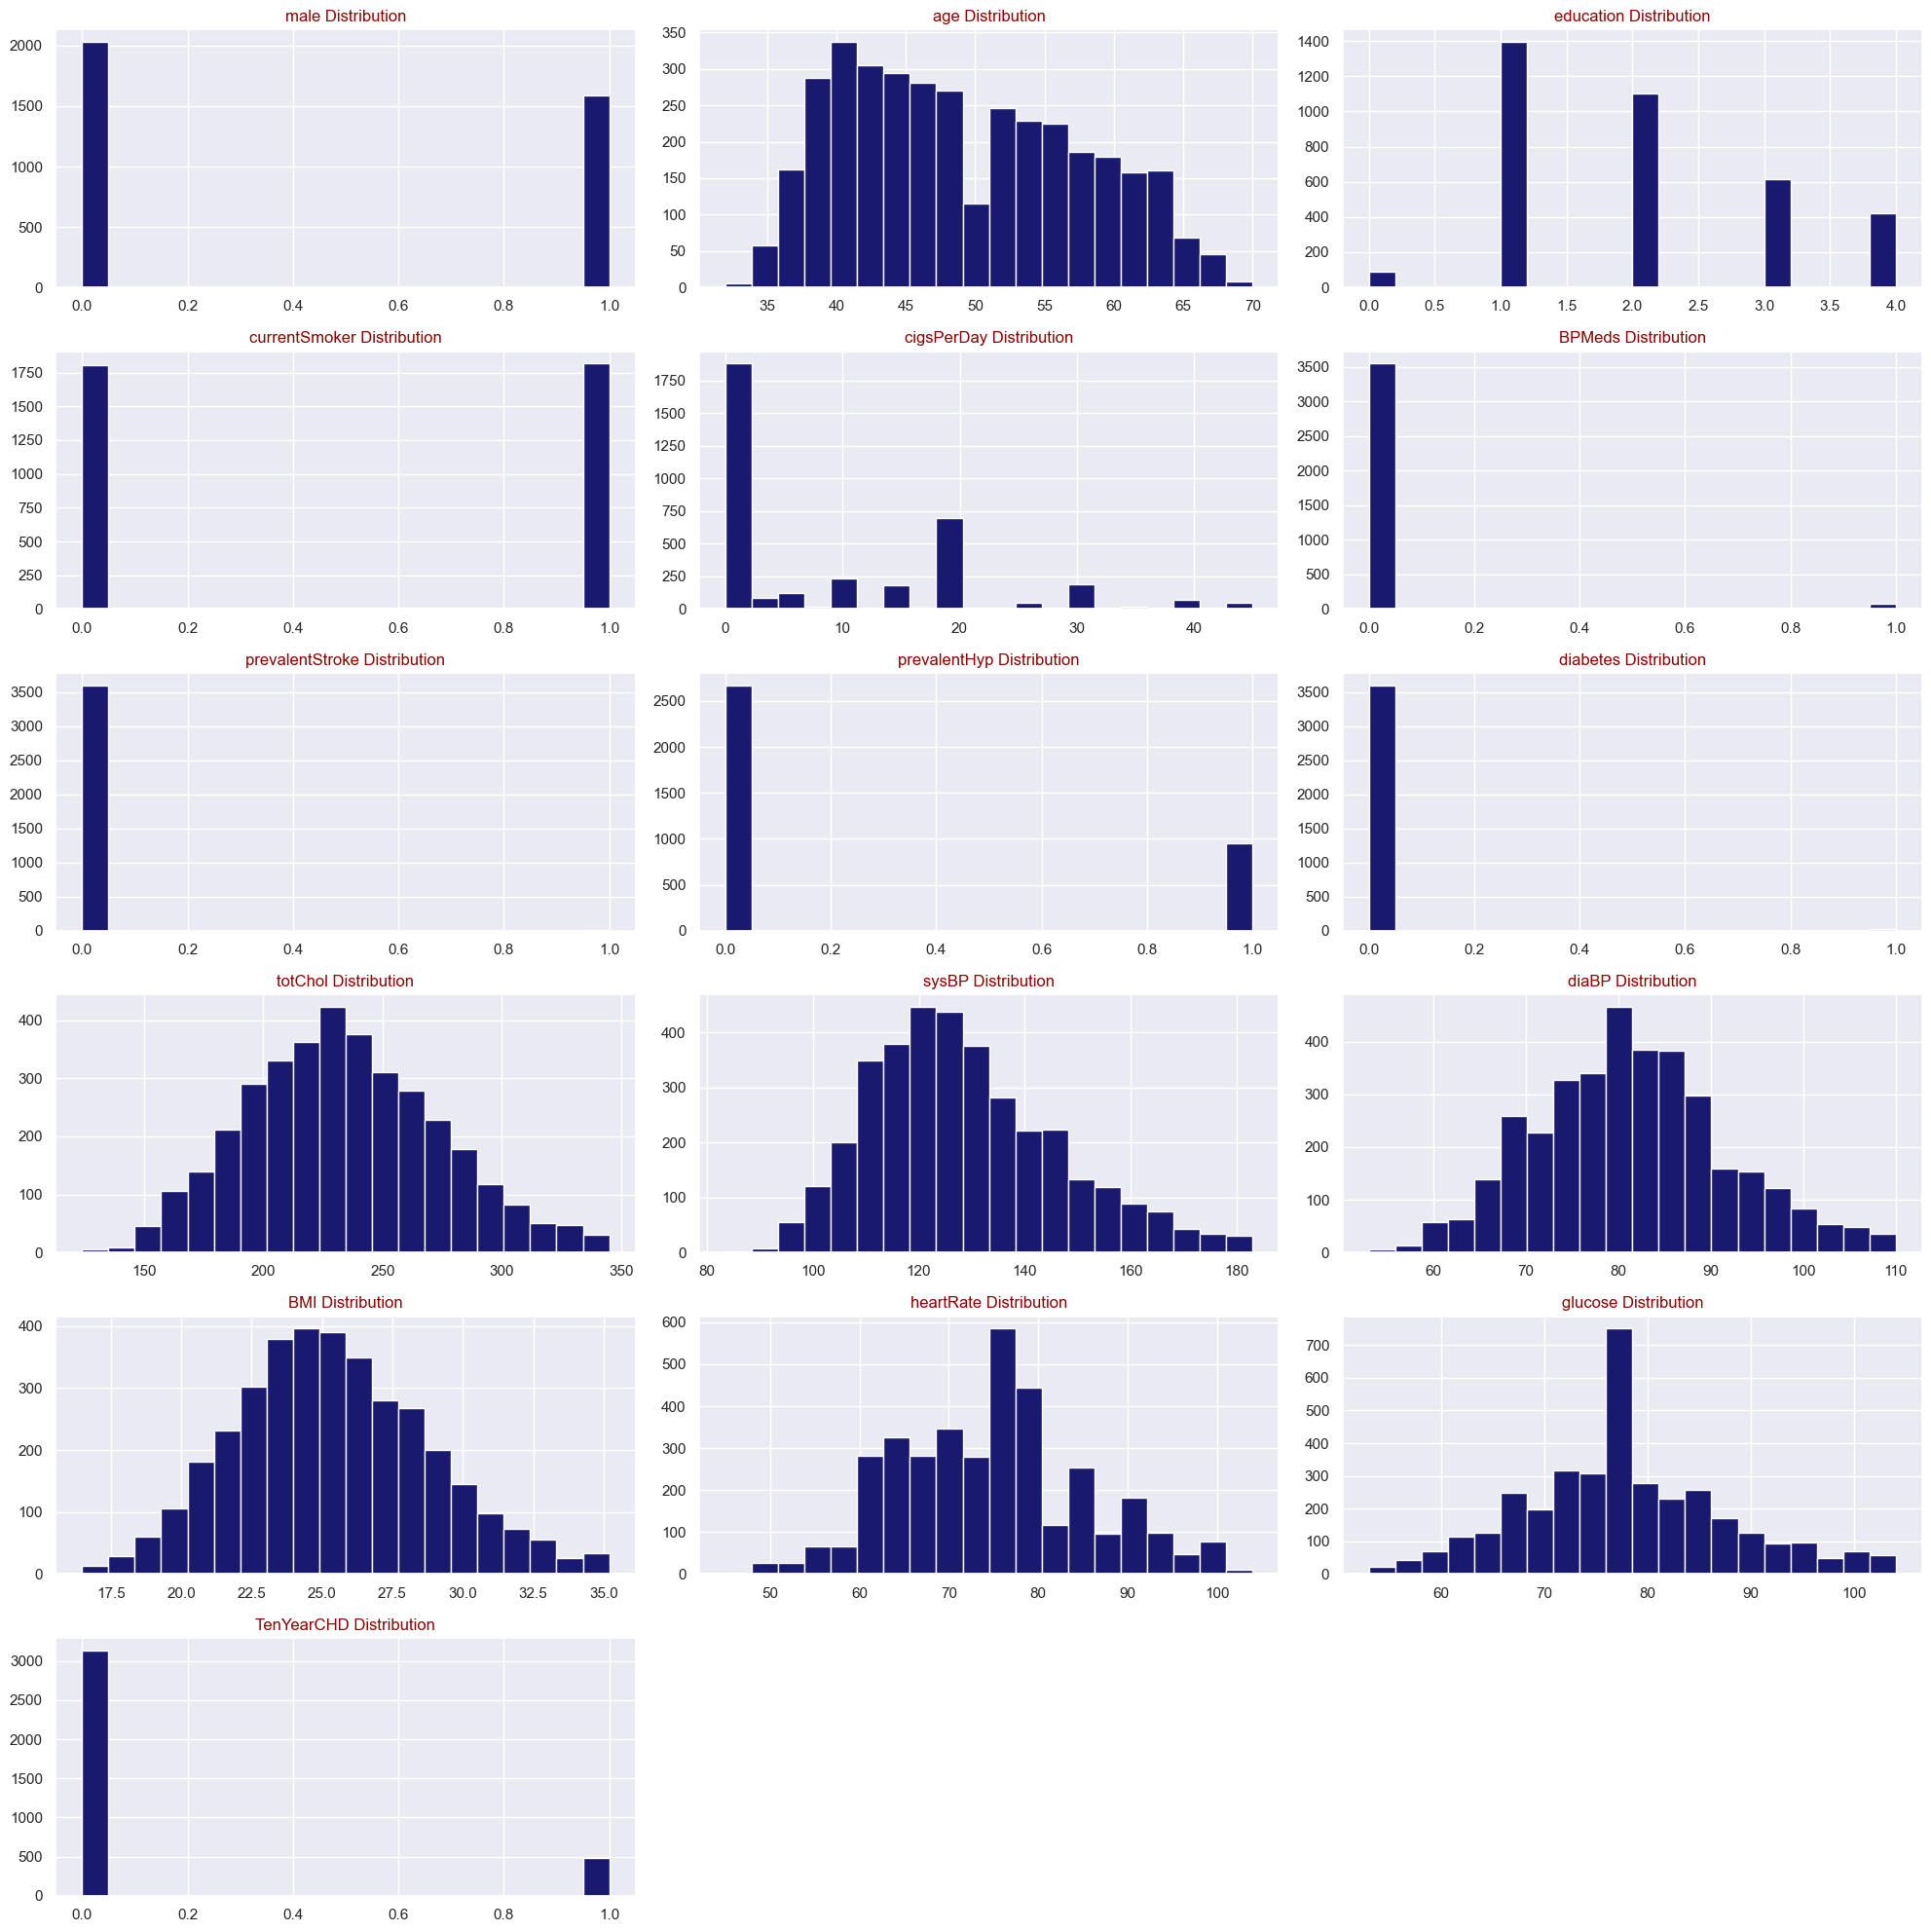

In [16]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(heartData,heartData.columns,6,3)

In [17]:
heartData.TenYearCHD.value_counts()

TenYearCHD
0    3138
1     482
Name: count, dtype: int64

<Axes: xlabel='TenYearCHD', ylabel='count'>

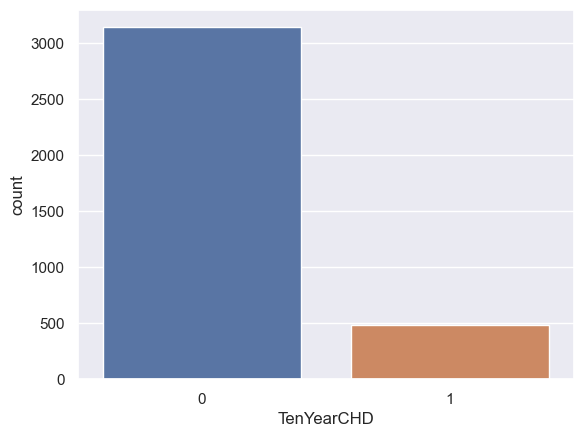

In [18]:
sb.countplot(x='TenYearCHD',data=heartData)

There are 3138 patients with no heart disease and 482 patients with risk of heart disease

We will generate a correlation matrix to evaluate the relationship between every variables in the data set by looking at its correlation coefficient.

<Figure size 1000x800 with 0 Axes>

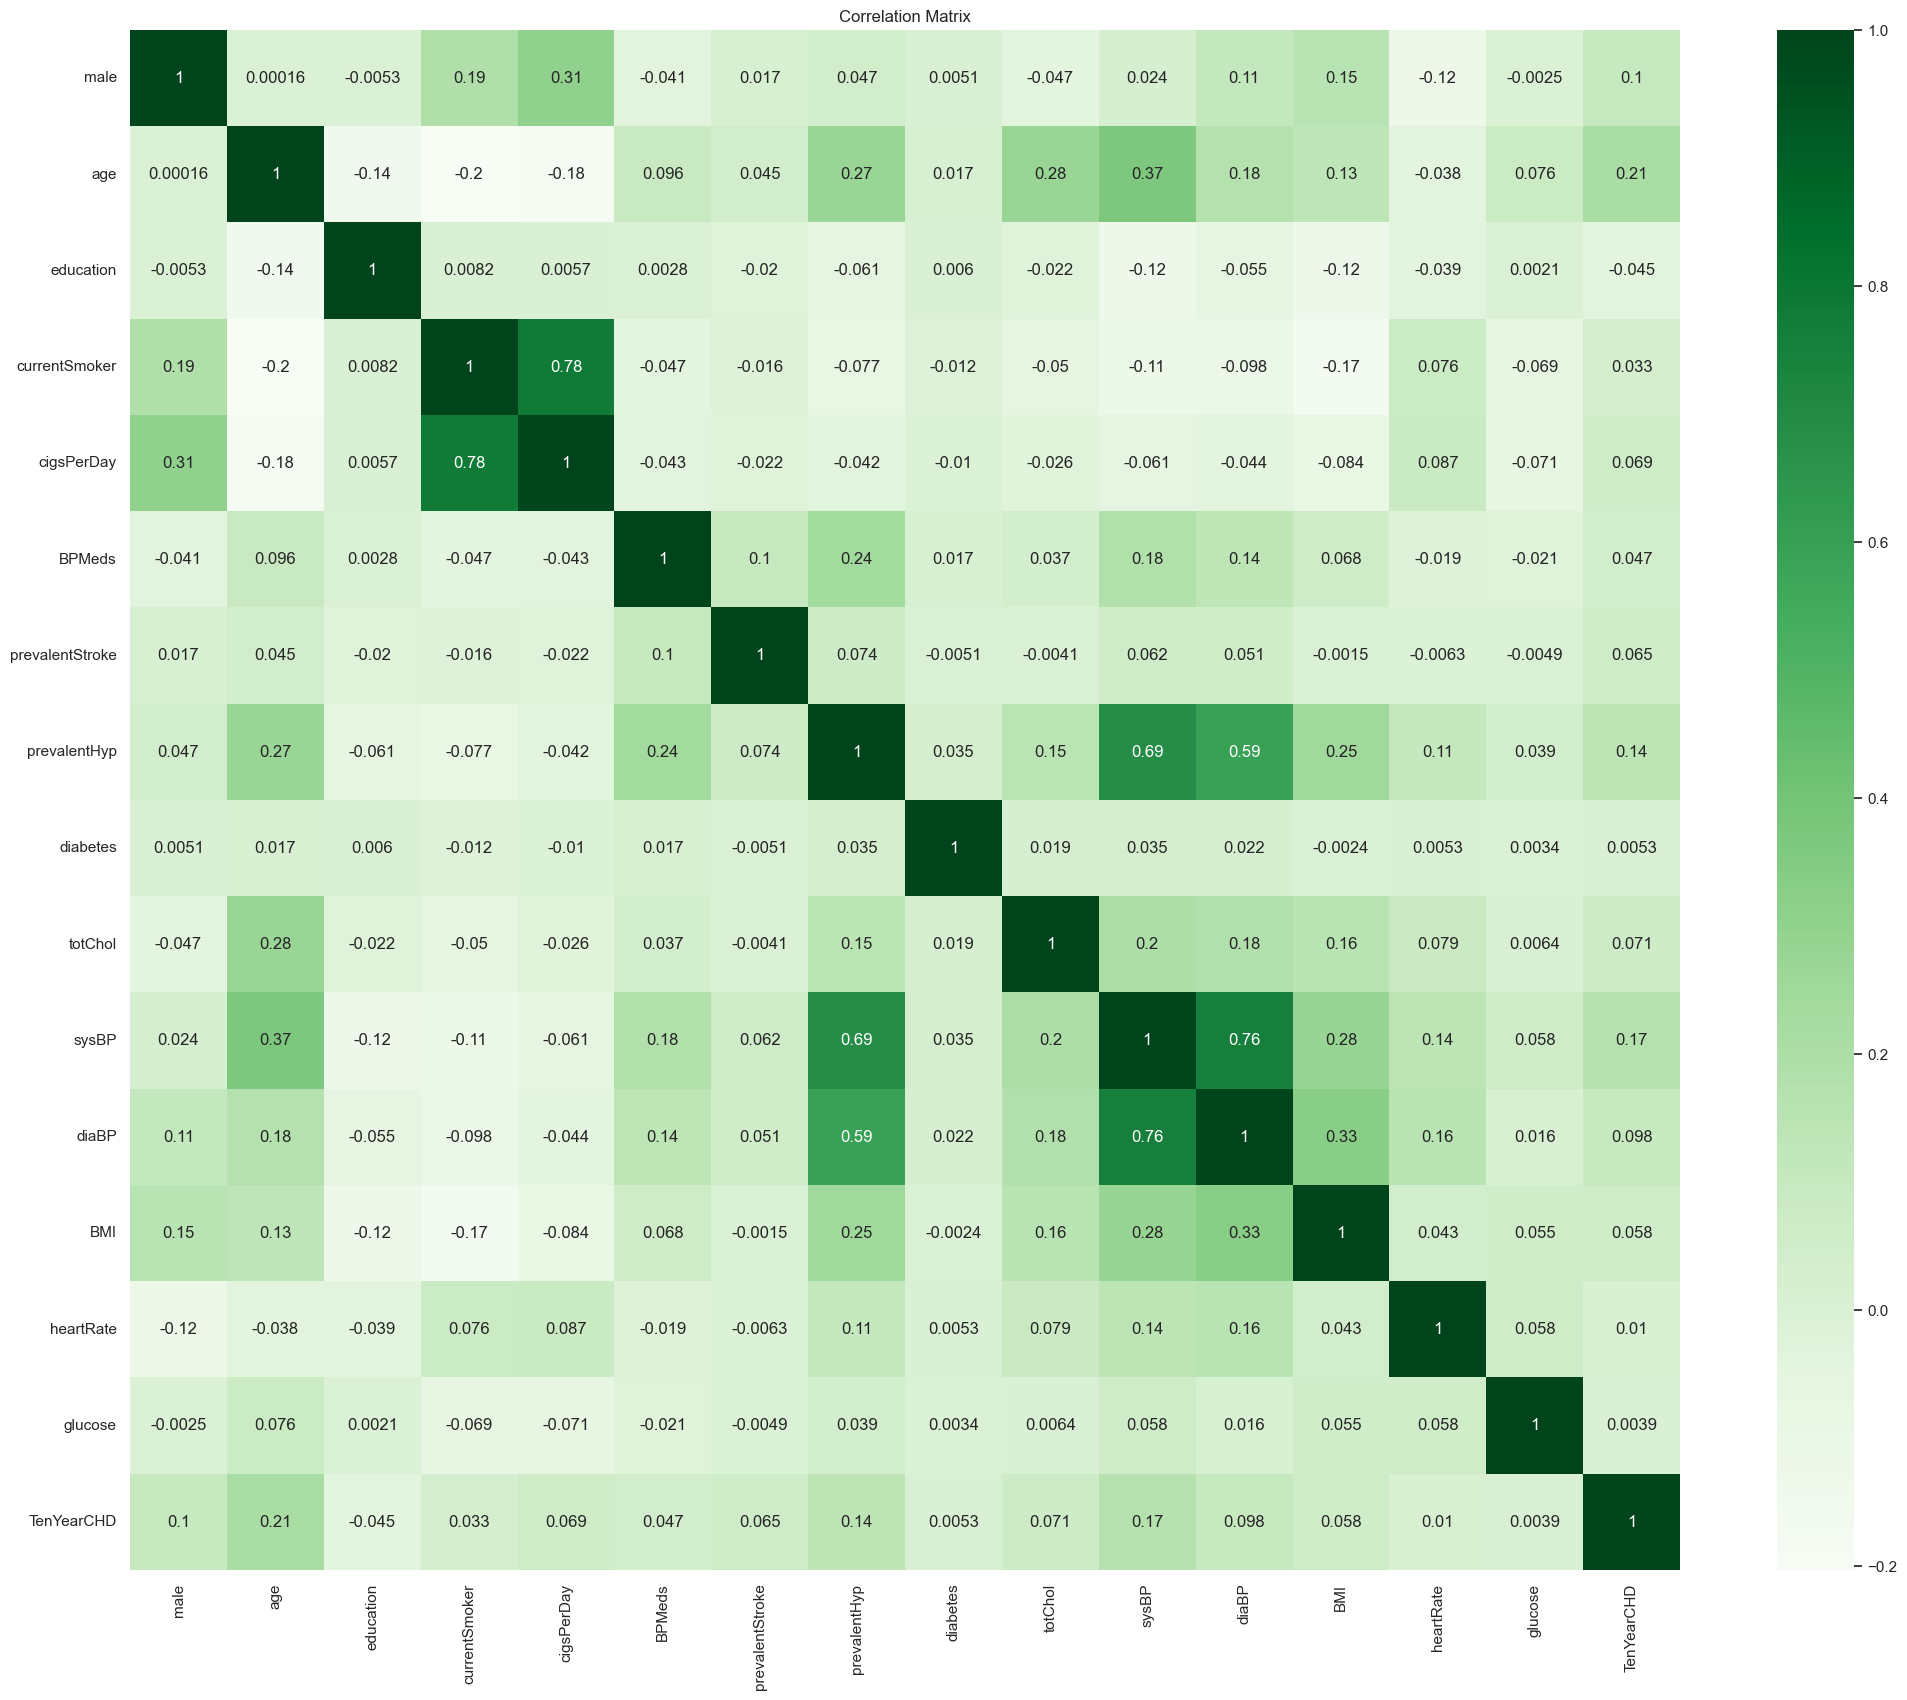

In [19]:
# Calculate the correlation matrix
correlation_matrix = heartData.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
fig , ax = plt.subplots(figsize=(25 , 20))
sb.heatmap(correlation_matrix, annot=True, cmap='Greens', ax=ax)
plt.title('Correlation Matrix')
plt.show()

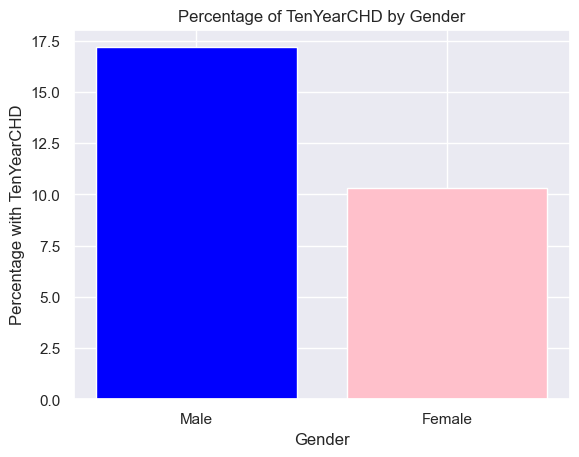

In [20]:
# Calculate percentage of males and females with TenYearCHD
male_chd_percentage = heartData[heartData['male'] == 1]['TenYearCHD'].mean() * 100
female_chd_percentage = heartData[heartData['male'] == 0]['TenYearCHD'].mean() * 100

# Plotting
plt.bar(['Male', 'Female'], [male_chd_percentage, female_chd_percentage], color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Gender')
plt.show()

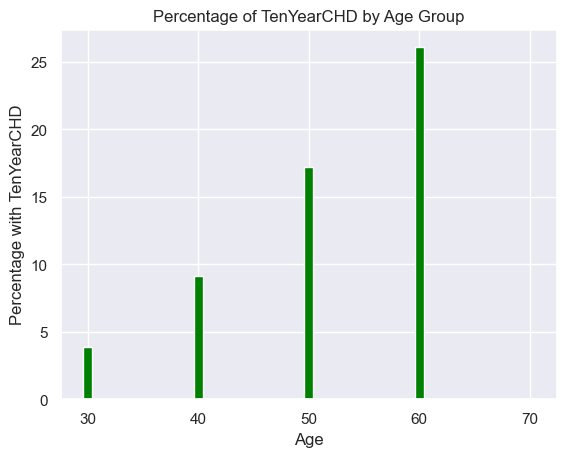

In [21]:
# Calculate percentage of individuals in different age groups with TenYearCHD
age_groups = [30, 40, 50, 60, 70]
age_chd_percentage = []

for age in age_groups:
    chd_percentage = heartData[(heartData['age'] >= age) & (heartData['age'] < age + 10)]['TenYearCHD'].mean() * 100
    age_chd_percentage.append(chd_percentage)

# Plotting
plt.bar(age_groups, age_chd_percentage, color='green')
plt.xlabel('Age')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Age Group')
plt.xticks(age_groups)
plt.show()

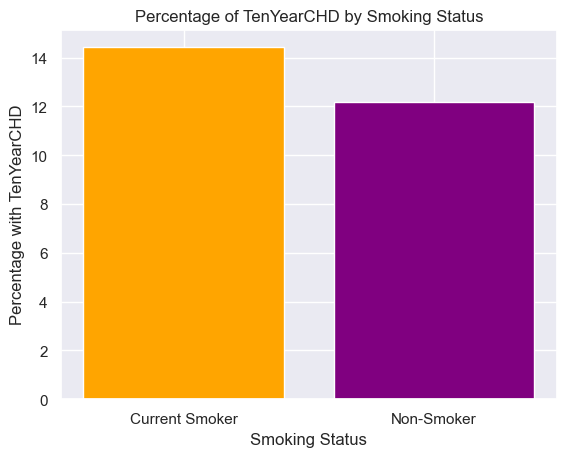

In [22]:
# Calculate percentage of current smokers and non-smokers with TenYearCHD
current_smoker_chd_percentage = heartData[heartData['currentSmoker'] == 1]['TenYearCHD'].mean() * 100
non_smoker_chd_percentage = heartData[heartData['currentSmoker'] == 0]['TenYearCHD'].mean() * 100

# Plotting
plt.bar(['Current Smoker', 'Non-Smoker'], [current_smoker_chd_percentage, non_smoker_chd_percentage], color=['orange', 'purple'])
plt.xlabel('Smoking Status')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Smoking Status')
plt.show()

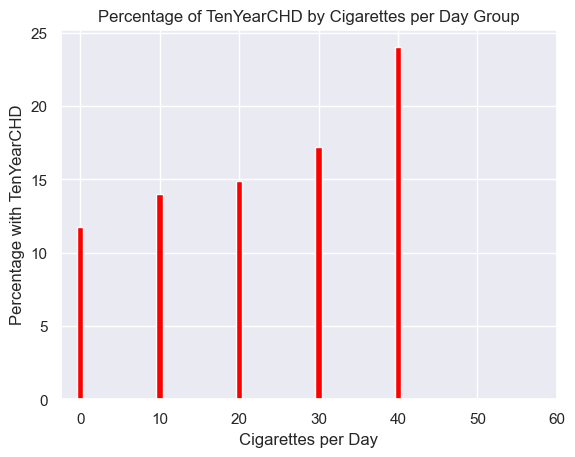

In [23]:
# Calculate percentage of individuals in different cigarette per day groups with TenYearCHD
cigs_per_day_groups = [0, 10, 20, 30, 40, 50,60]
cigs_per_day_chd_percentage = []

for cigs_per_day in cigs_per_day_groups:
    chd_percentage = heartData[(heartData['cigsPerDay'] >= cigs_per_day) & (heartData['cigsPerDay'] < cigs_per_day + 10)]['TenYearCHD'].mean() * 100
    cigs_per_day_chd_percentage.append(chd_percentage)

# Plotting
plt.bar(cigs_per_day_groups, cigs_per_day_chd_percentage, color='red')
plt.xlabel('Cigarettes per Day')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Cigarettes per Day Group')
plt.xticks(cigs_per_day_groups)
plt.show()

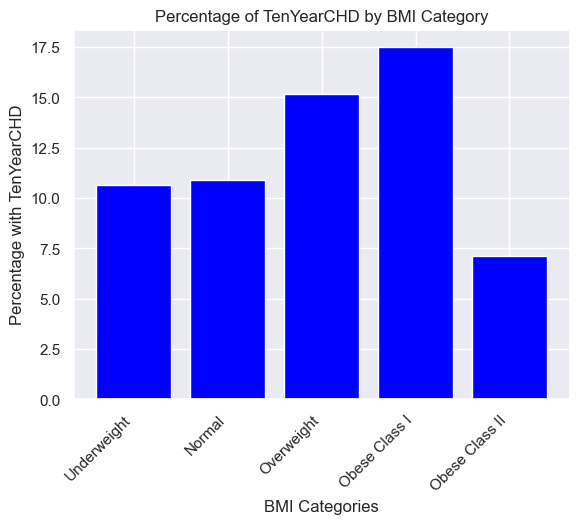

In [24]:
bmi_groups = [0, 18.5, 25, 30, 35, 40, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese Class I', 'Obese Class II', 'Obese Class III']
bmi_chd_percentage = []

for i in range(len(bmi_groups) - 1):
    lower_bound = bmi_groups[i]
    upper_bound = bmi_groups[i + 1]
    chd_percentage = heartData[(heartData['BMI'] >= lower_bound) & (heartData['BMI'] < upper_bound)]['TenYearCHD'].mean() * 100
    bmi_chd_percentage.append(chd_percentage)

# Plotting
plt.bar(bmi_labels, bmi_chd_percentage, color='blue')
plt.xlabel('BMI Categories')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by BMI Category')
plt.xticks(rotation=45, ha='right')
plt.show()

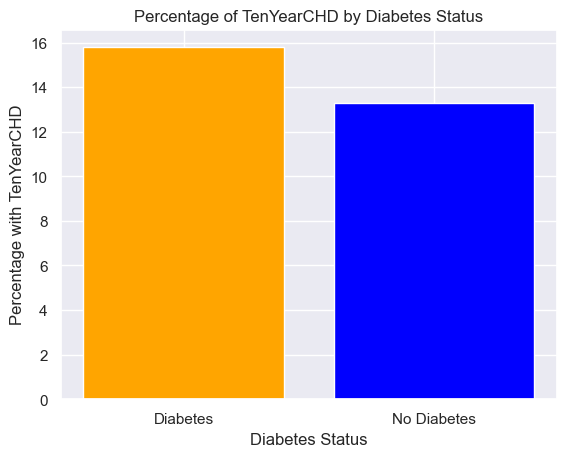

In [25]:
diabetes_chd_percentage = heartData[heartData['diabetes'] == 1]['TenYearCHD'].mean() * 100
no_diabetes_chd_percentage = heartData[heartData['diabetes'] == 0]['TenYearCHD'].mean() * 100

# Plotting
plt.bar(['Diabetes', 'No Diabetes'], [diabetes_chd_percentage, no_diabetes_chd_percentage], color=['orange', 'blue'])
plt.xlabel('Diabetes Status')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Diabetes Status')
plt.show()

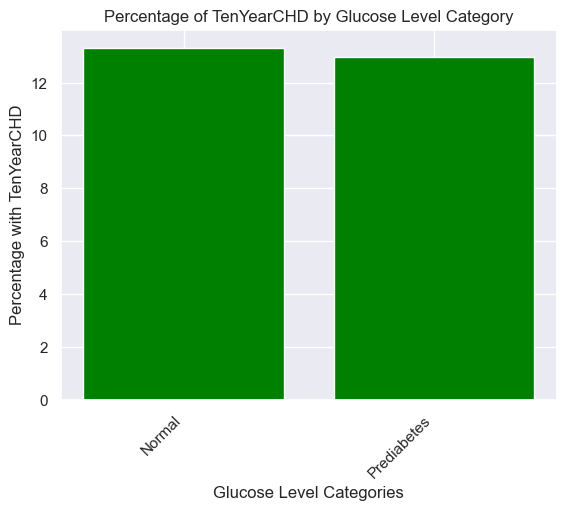

In [26]:
# Calculate percentage of individuals in different glucose level groups with TenYearCHD
glucose_groups = [0, 100, 125, 150, 200, float('inf')]
glucose_labels = ['Normal', 'Prediabetes', 'Borderline Diabetes', 'Diabetes', 'Severe Diabetes']
glucose_chd_percentage = []

for i in range(len(glucose_groups) - 1):
    lower_bound = glucose_groups[i]
    upper_bound = glucose_groups[i + 1]
    chd_percentage = heartData[(heartData['glucose'] >= lower_bound) & (heartData['glucose'] < upper_bound)]['TenYearCHD'].mean() * 100
    glucose_chd_percentage.append(chd_percentage)

# Plotting
plt.bar(glucose_labels, glucose_chd_percentage, color='green')
plt.xlabel('Glucose Level Categories')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Glucose Level Category')
plt.xticks(rotation=45, ha='right')
plt.show()

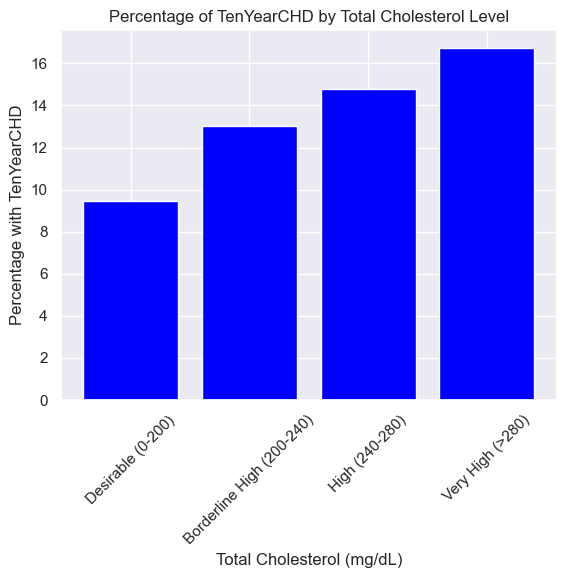

In [27]:
totChol_bins = [0, 200, 240, 280, float('inf')]
totChol_labels = ['Desirable (0-200)', 'Borderline High (200-240)', 'High (240-280)', 'Very High (>280)']

# Calculate percentage of TenYearCHD for each bin
totChol_chd_percentage = []
for i in range(len(totChol_bins) - 1):
    lower_bound = totChol_bins[i]
    upper_bound = totChol_bins[i + 1]
    chd_percentage = heartData[(heartData['totChol'] >= lower_bound) & (heartData['totChol'] < upper_bound)]['TenYearCHD'].mean() * 100
    totChol_chd_percentage.append(chd_percentage)

# Plotting
plt.bar(totChol_labels, totChol_chd_percentage, color='blue')
plt.xlabel('Total Cholesterol (mg/dL)')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Total Cholesterol Level')
plt.xticks(rotation=45)
plt.show()

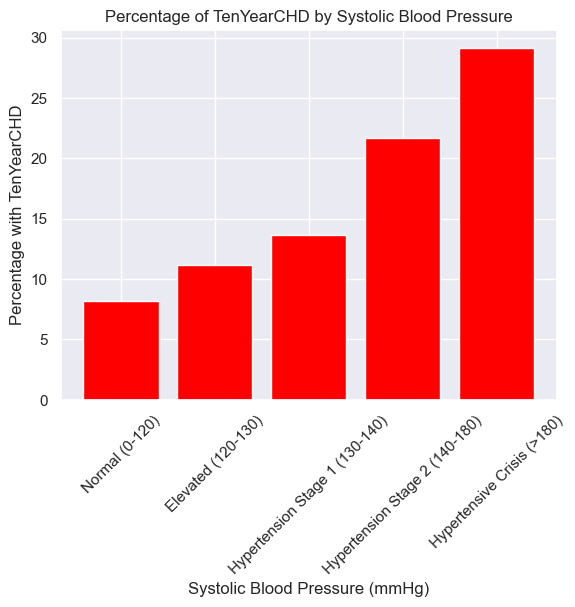

In [28]:
sysBP_bins = [0, 120, 130, 140, 180, float('inf')]
sysBP_labels = ['Normal (0-120)', 'Elevated (120-130)', 'Hypertension Stage 1 (130-140)', 'Hypertension Stage 2 (140-180)', 'Hypertensive Crisis (>180)']

# Calculate percentage of TenYearCHD for each bin of sysBP
sysBP_chd_percentage = []
for i in range(len(sysBP_bins) - 1):
    lower_bound = sysBP_bins[i]
    upper_bound = sysBP_bins[i + 1]
    chd_percentage = heartData[(heartData['sysBP'] >= lower_bound) & (heartData['sysBP'] < upper_bound)]['TenYearCHD'].mean() * 100
    sysBP_chd_percentage.append(chd_percentage)

# Plotting sysBP
plt.bar(sysBP_labels, sysBP_chd_percentage, color='red')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Systolic Blood Pressure')
plt.xticks(rotation=45)
plt.show()

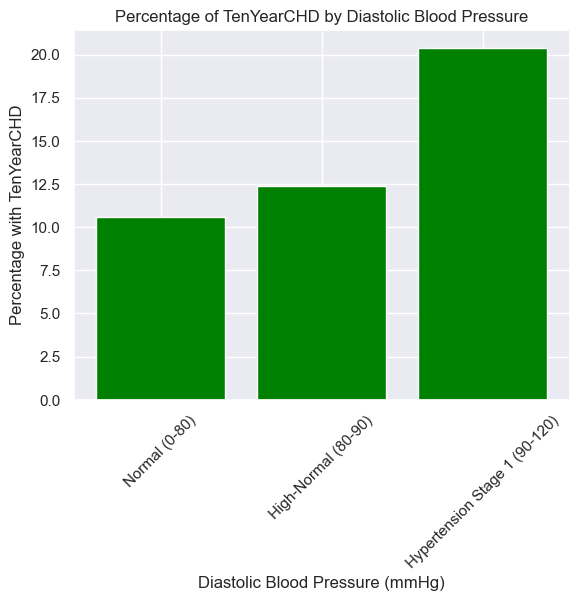

In [29]:
# Define bins for Diastolic Blood Pressure (diaBP)
diaBP_bins = [0, 80, 90, 120, float('inf')]
diaBP_labels = ['Normal (0-80)', 'High-Normal (80-90)', 'Hypertension Stage 1 (90-120)', 'Hypertension Stage 2 (>120)']

# Calculate percentage of TenYearCHD for each bin of diaBP
diaBP_chd_percentage = []
for i in range(len(diaBP_bins) - 1):
    lower_bound = diaBP_bins[i]
    upper_bound = diaBP_bins[i + 1]
    chd_percentage = heartData[(heartData['diaBP'] >= lower_bound) & (heartData['diaBP'] < upper_bound)]['TenYearCHD'].mean() * 100
    diaBP_chd_percentage.append(chd_percentage)

# Plotting diaBP
plt.bar(diaBP_labels, diaBP_chd_percentage, color='green')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Percentage with TenYearCHD')
plt.title('Percentage of TenYearCHD by Diastolic Blood Pressure')
plt.xticks(rotation=45)
plt.show()

Summary of results

# 4. Exploring of Machine Learning Techniques
Now we explored the variables, we will be trying out different machine learning techniques to see which methods gives the best accuracy and using the confusion matrix to try out the prediction using test values.
<br>
We will be predicting TenYearCHD using the rest of variables. TenYearCHD is a boolean data type consisting of 0 and 1 (True and False), so machine learning techniques catering to classification will be explored.

In [30]:
#Importing additional libraries for graph plotting of model results
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

In [31]:
X = heartData.drop('TenYearCHD' , axis= 'columns')
y = heartData['TenYearCHD']

Create appropriate datasets for Train and Test in an 80:20 ratio.

In [32]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2 , shuffle=True , random_state=4)

In [33]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Baseline Classifer
A baseline classifier will be used to provide a simple, minimalistic model that serves as a reference point for evaluating the performance of more complex models. This establish a performance benchmark when we make our comparison with other models and our final justification in picking the best machine learning technique to generate the final model for our predicition.

In [34]:
#baseline classifier

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train , y_train)
y_pred = dummy_classifier.predict(X_test)
accuracy = accuracy_score(y_test , y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.8826


## Logistic Regression
A regression analysis describe data and explain relationship between 1 binary variable and one or more nominal, ordinal or interval independent variables. The outcome from this analysis will give a 'Yes' or 'No' result.

In [35]:
#logistic regression model

lr_model = make_pipeline(SimpleImputer(strategy='mean') , MinMaxScaler() , LogisticRegression(penalty='l2' , C= 12 ,max_iter=1500))
lr_model.fit(X_train , y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=12, max_iter=1500))])

In [36]:
lr_model.score(X_train , y_train)

0.8660220994475138

In [37]:
lr_pred = lr_model.predict(X_test)
lr_acc_score = accuracy_score(y_test , lr_pred)
lr_acc_score

0.8839779005524862

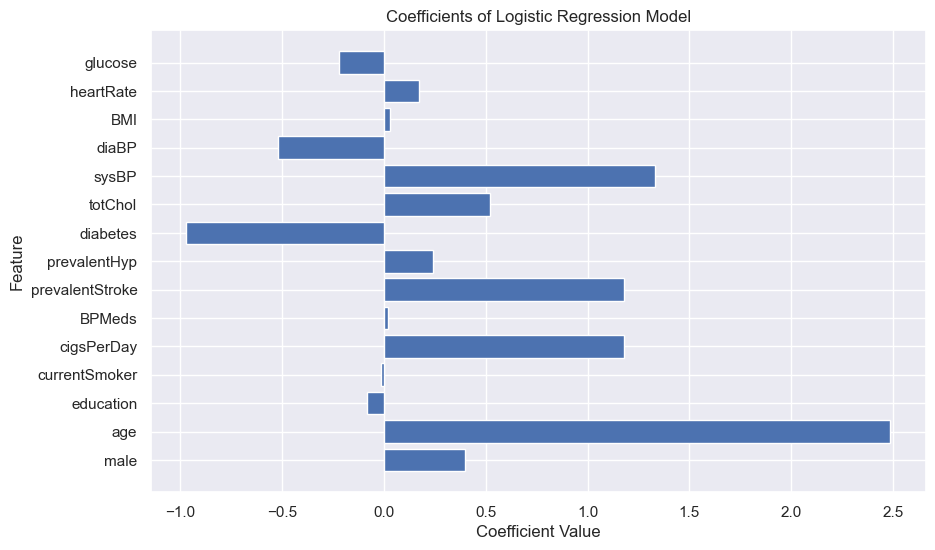

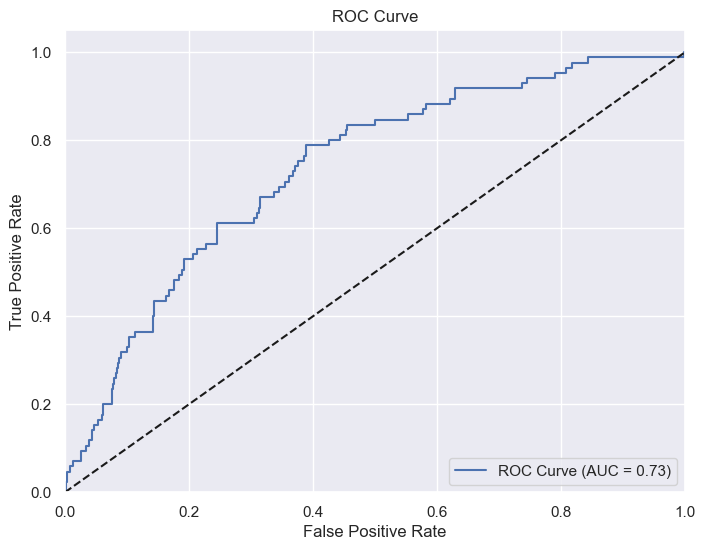

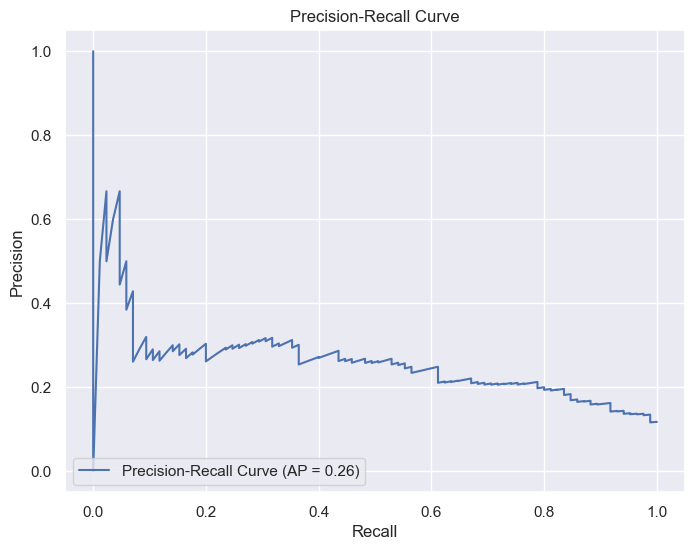

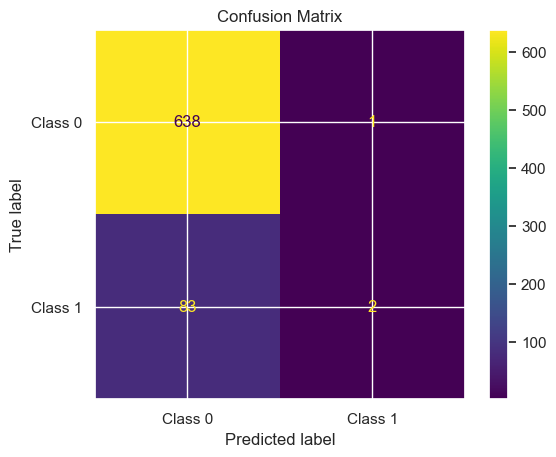

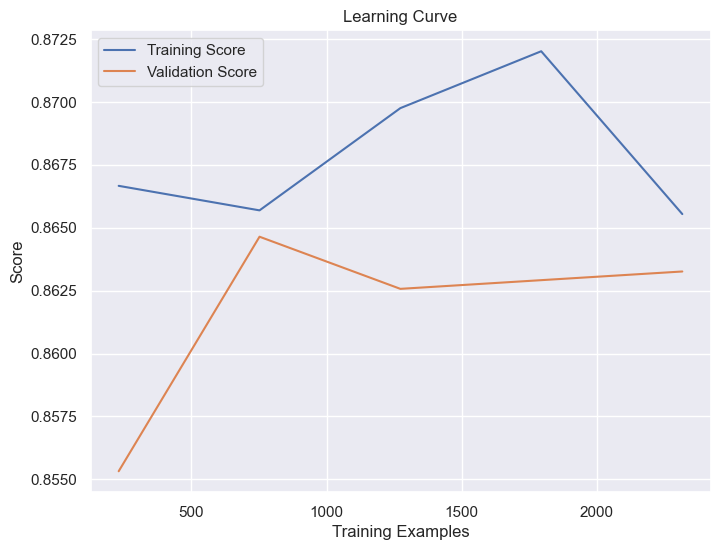

In [38]:
# Coefficients Plot
coefficients = lr_model.named_steps['logisticregression'].coef_.flatten()
feature_names = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Logistic Regression Model')
plt.show()

# ROC Curve
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve (AP = {:.2f})'.format(average_precision_score(y_test, y_pred_proba)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Confusion Matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lr_model.predict(X_test)), display_labels=["Class 0", "Class 1"])
confusion_matrix_display.plot()
plt.title('Confusion Matrix')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(lr_model, X_train, y_train, cv=5)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

In [39]:
#Print out FPR TPR

## Decision Tree

In [40]:
#decision tree model

dt_model = make_pipeline(SimpleImputer(strategy='mean') , MinMaxScaler() , DecisionTreeClassifier())
dt_model.fit(X_train , y_train)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [41]:
dt_pred = dt_model.predict(X_test)
dt_acc_score = accuracy_score(y_test , dt_pred)
dt_acc_score

0.7707182320441989

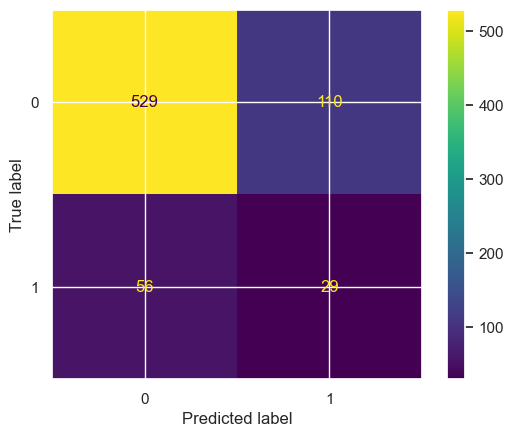

In [42]:
ConfusionMatrixDisplay.from_estimator(dt_model , X_test , y_test);

In [43]:
#Print out FPR TPR

## Random Forest

In [44]:
#random forest model

rf_model = make_pipeline(SimpleImputer(strategy='mean') , MinMaxScaler() , RandomForestClassifier(n_estimators=500))
rf_model.fit(X_train , y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=500))])

In [45]:
y_pred_train = rf_model.predict(X_train)
y_prob_train = rf_model.predict_proba(X_train)[:,1]

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:,1]

print('Classification report for test:\n',classification_report(y_test,y_pred))

Classification report for test:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       639
           1       0.50      0.02      0.04        85

    accuracy                           0.88       724
   macro avg       0.69      0.51      0.49       724
weighted avg       0.84      0.88      0.83       724



In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

rfc = RandomForestClassifier(random_state=1)

params = {
    'n_estimators': sp_randint(5, 25),
    'criterion': ['gini', 'entropy'],
    'max_depth': sp_randint(2, 10),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': sp_randint(2, 15)
}

rand_search_rfc = RandomizedSearchCV(rfc, param_distributions=params, cv=3, random_state=1)

rand_search_rfc.fit(X, y)
print(rand_search_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 2, 'min_samples_leaf': 17, 'min_samples_split': 3, 'n_estimators': 17}


In [47]:
rfc = RandomForestClassifier(**rand_search_rfc.best_params_)

rfc.fit(X_train, y_train)

y_pred_train = rfc.predict(X_train)
y_prob_train = rfc.predict_proba(X_train)[:, 1]

y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)[:, 1]

print('Classification report for test:\n', classification_report(y_test, y_pred))

Classification report for test:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       639
           1       0.00      0.00      0.00        85

    accuracy                           0.88       724
   macro avg       0.44      0.50      0.47       724
weighted avg       0.78      0.88      0.83       724



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
